TODO:

- run logs for 400k, 600k and test generalization of these models
- might need some additional information about time between interrupts (additional column)

Status:

- there's signal in the spectrum (distribution of eigenvalues) about the true latency
- question: what's the interpretation of this? do we need one (it would be nice but not necessary for predictions)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv('lat_eig_200k.csv')
df.head()

,desc,avg,std,min,5th,10th,50th,90th,95th,99th,...,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13
0,0_100_0x1d00_135_200000,100.3,31.5,37.4,51.3,57.3,100.6,141.1,151.5,171.5,...,0.440060,0.000859,0.000327,0.000053,0.000017,0.000011,7.398808e-06,2.850891e-06,1.803686e-07,9.683146e-08
1,0_10_0x1d00_135_200000,49.1,4.6,34.0,42.2,43.3,48.5,55.5,58.5,64.5,...,0.162246,0.003525,0.000319,0.000128,0.000045,0.000021,3.140831e-06,1.732030e-07,3.880479e-08,1.932744e-13
2,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.424921,0.066377,0.001418,0.000451,0.000151,0.000032,1.899372e-05,2.834952e-07,1.581454e-06,1.421811e-06
3,0_40_0x1d00_135_200000,60.9,12.9,34.0,43.8,45.9,58.7,79.1,83.4,88.1,...,0.505817,0.004241,0.000343,0.000143,0.000019,0.000007,9.731156e-07,4.427437e-07,2.197987e-07,1.825507e-09
4,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.411281,0.021113,0.003975,0.000559,0.000281,0.000061,1.589944e-05,6.504408e-06,6.299850e-07,1.045465e-06


In [3]:
df['itr'] = df['desc'].apply(lambda x: int(x.split('_')[1]))
df['dvfs'] = df['desc'].apply(lambda x: int(x.split('_')[2], base=16))

In [4]:
df.head()

,desc,avg,std,min,5th,10th,50th,90th,95th,99th,...,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,itr,dvfs
0,0_100_0x1d00_135_200000,100.3,31.5,37.4,51.3,57.3,100.6,141.1,151.5,171.5,...,0.000327,0.000053,0.000017,0.000011,7.398808e-06,2.850891e-06,1.803686e-07,9.683146e-08,100,7424
1,0_10_0x1d00_135_200000,49.1,4.6,34.0,42.2,43.3,48.5,55.5,58.5,64.5,...,0.000319,0.000128,0.000045,0.000021,3.140831e-06,1.732030e-07,3.880479e-08,1.932744e-13,10,7424
2,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.001418,0.000451,0.000151,0.000032,1.899372e-05,2.834952e-07,1.581454e-06,1.421811e-06,350,7424
3,0_40_0x1d00_135_200000,60.9,12.9,34.0,43.8,45.9,58.7,79.1,83.4,88.1,...,0.000343,0.000143,0.000019,0.000007,9.731156e-07,4.427437e-07,2.197987e-07,1.825507e-09,40,7424
4,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.003975,0.000559,0.000281,0.000061,1.589944e-05,6.504408e-06,6.299850e-07,1.045465e-06,350,7424


In [5]:
eig_cols = [c for c in df if c.find('eig')>-1]
eig_cols

['eig_0',
 'eig_1',
 'eig_2',
 'eig_3',
 'eig_4',
 'eig_5',
 'eig_6',
 'eig_7',
 'eig_8',
 'eig_9',
 'eig_10',
 'eig_11',
 'eig_12',
 'eig_13']

In [6]:
#should add to n where correlation matrix is n x n since Tr(C) = n
df[eig_cols].sum(axis=1).unique()

array([14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14.])

In [7]:
#correlation matrix C = X^T X i.e. positive definite -> eigenvalues should be positive
(df[eig_cols] <= 0).sum().sum()

0

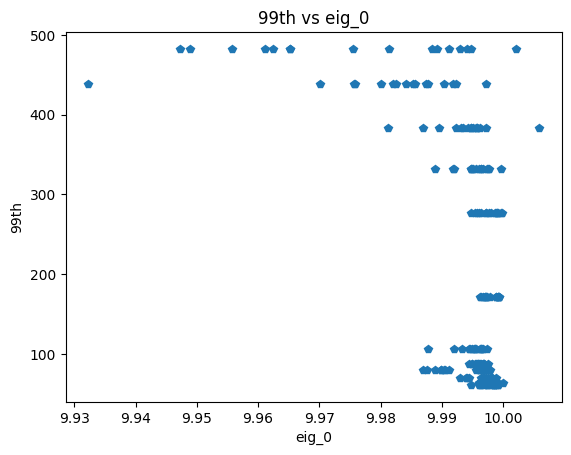

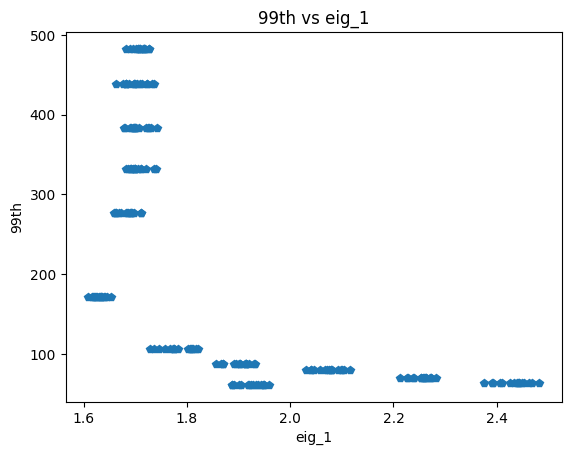

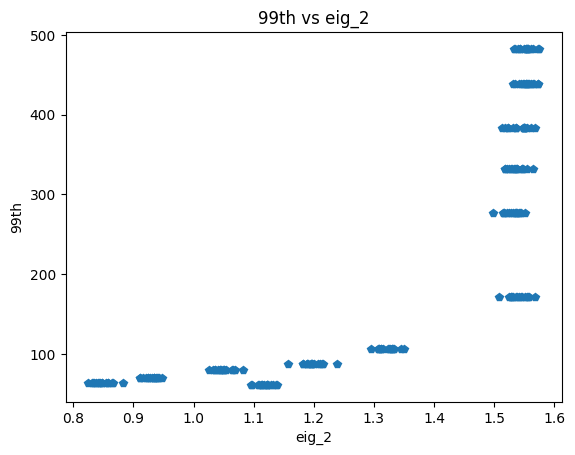

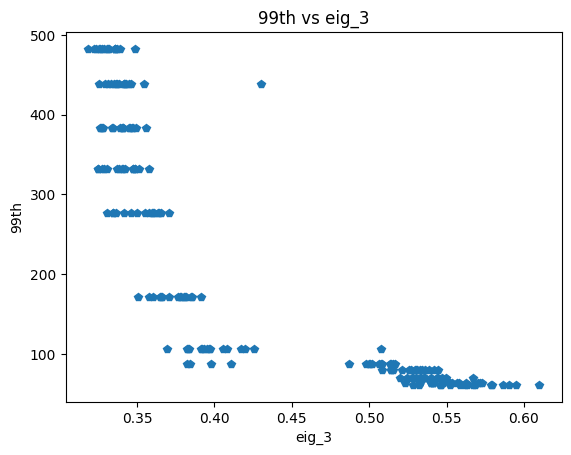

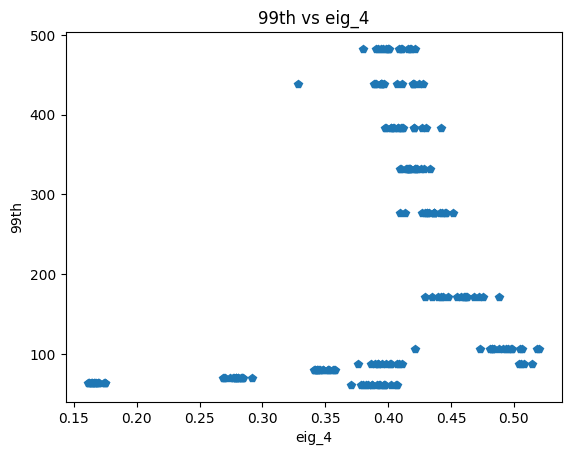

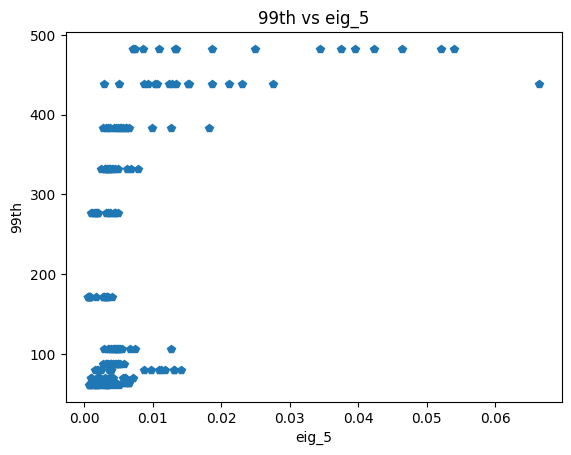

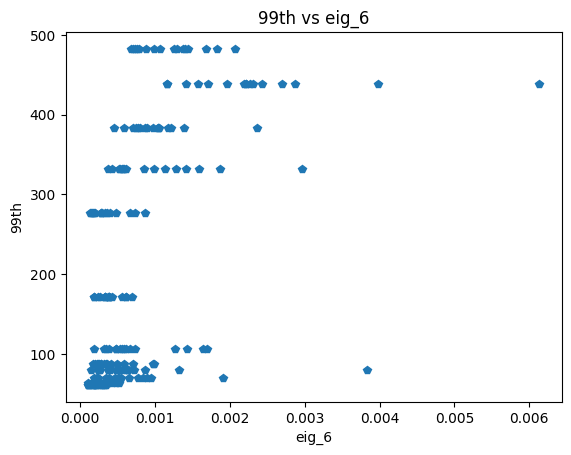

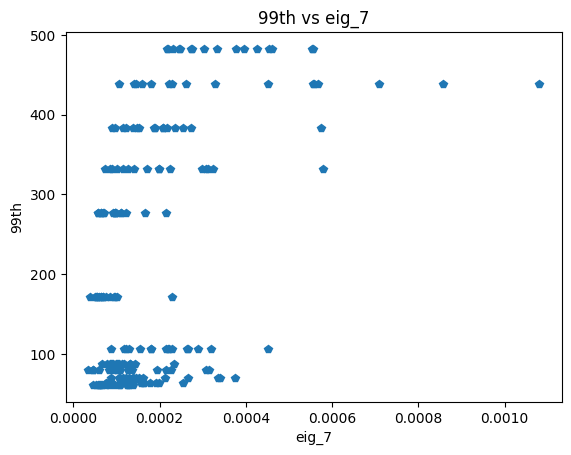

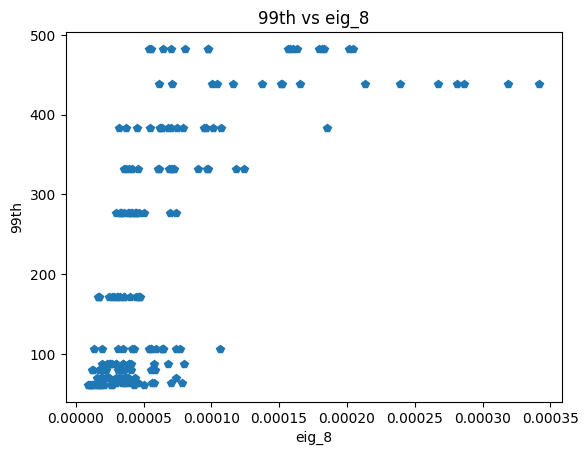

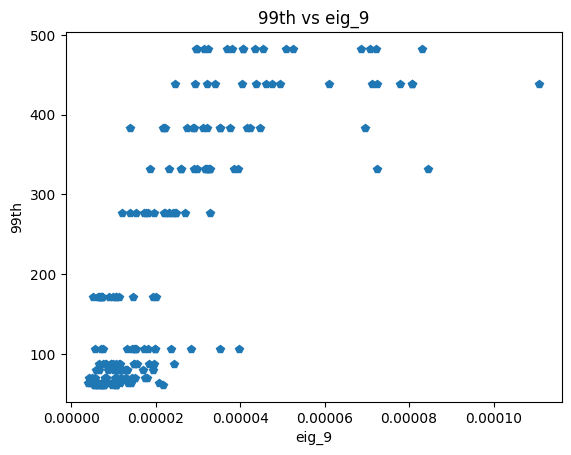

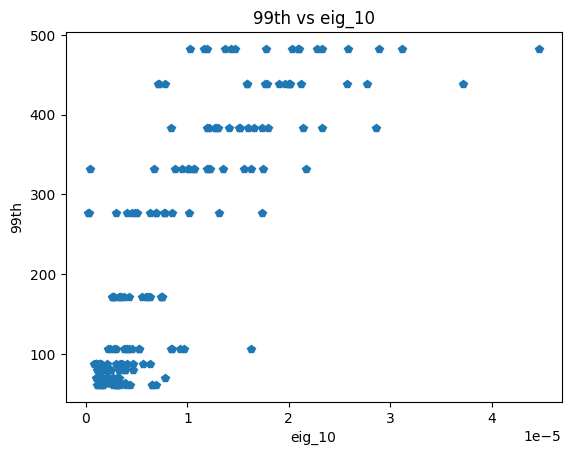

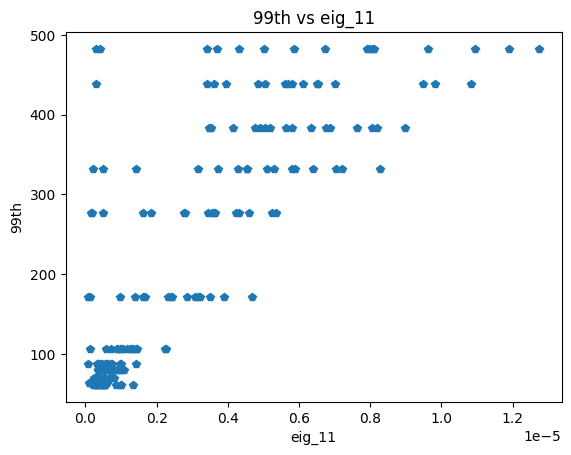

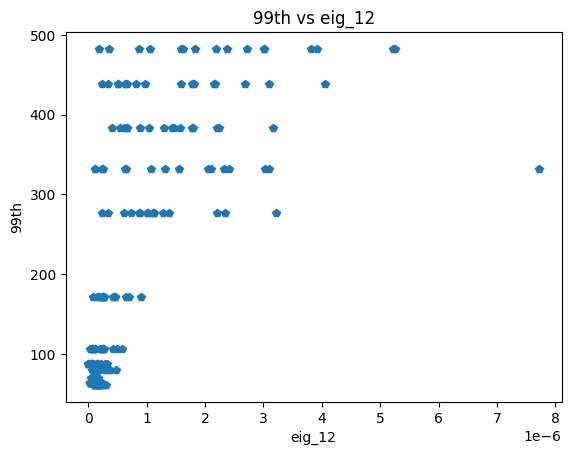

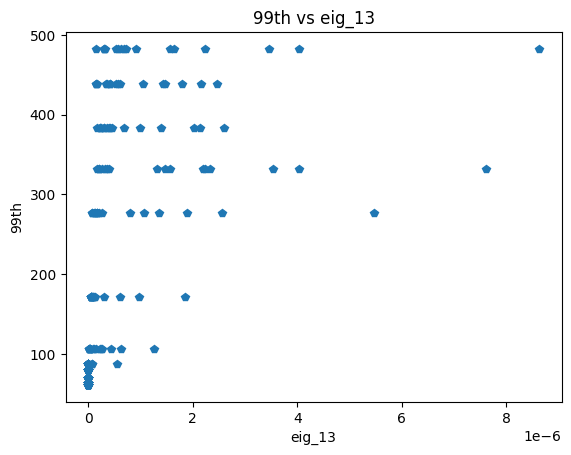

In [8]:
#plot kth eigenvalue vs latency
lat_col = '99th'
for c in eig_cols:
    plt.figure()
    plt.plot(df[c], df[lat_col], 'p')
    plt.xlabel(c)
    plt.ylabel(lat_col)
    plt.title(f'{lat_col} vs {c}')

In [67]:
n_iter = 10

scale = True
ratios = True
log = False

scorer = r2_score

def run_exp(model,
            df,
            scale=True, 
            ratios=True, 
            log=False, 
            n_iter=10, 
            scorer=r2_score,
            plot=False):

    score_list, model_list = [], []

    for i in range(n_iter):
        #split into train and test sets
        df_train, df_test = train_test_split(df, train_size=0.7)
        
        if i==0: print(df_train.shape, df_test.shape)

        #define features to be eigenvalues
        df_train_feats = df_train[eig_cols].copy()
        df_test_feats = df_test[eig_cols].copy()
    
        #define latency column to be target
        df_train_y = df_train[lat_col].copy()
        df_test_y = df_test[lat_col].copy()
    
        #
        if ratios: #features are scaled by highest eigenvalue (assumed to be eig_0 although should check this)
            for c in eig_cols:
                df_train_feats[c] = df_train_feats[c] / df_train_feats['eig_0']
                df_test_feats[c] = df_test_feats[c] / df_test_feats['eig_0']

            df_train_feats.drop('eig_0', axis=1, inplace=True)
            df_test_feats.drop('eig_0', axis=1, inplace=True)

        feat_col_names = df_train_feats.columns

        if log: #take logs of features to suppress scales
            df_train_feats = df_train_feats.apply(lambda x: np.log(x), axis=1)
            df_test_feats = df_test_feats.apply(lambda x: np.log(x), axis=1)

        if scale: #standard normalization for linear models
            scaler = StandardScaler(with_mean=True, with_std=True)
            df_train_feats = scaler.fit_transform(df_train_feats)
            df_test_feats = scaler.transform(df_test_feats)

        model.fit(df_train_feats, df_train_y)

        pred_train = model.predict(df_train_feats)
        pred_test = model.predict(df_test_feats)

        labels_train = df_train_y
        labels_test = df_test_y
        
        if plot:
            plt.figure(figsize=(5,3))
            plt.plot(labels_train, pred_train, 'p', label='train')
            plt.plot(labels_test, pred_test, 'p', label='test')
            plt.plot(labels_train, labels_train, '-')
            plt.xlim((0, 500))
            plt.ylim((0, 500))
            plt.legend()
            plt.grid()
            plt.xlabel('labels')
            plt.ylabel('preds')

        train_score = scorer(pred_train, labels_train)
        test_score = scorer(pred_test, labels_test)

        score_list.append((train_score, test_score))
    
    return score_list, model, feat_col_names #this is the last trained model but ok for now

In [57]:
for model in LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor():

    score_list, model, feat_col_names = run_exp(model,
                                                df,
                                                scale=True, 
                                                ratios=True, 
                                                log=False, 
                                                n_iter=10, 
                                                scorer=r2_score,
                                                plot=False) #change plot->True to see plots

    score_mean, score_std = np.mean([i[1] for i in score_list]), np.std([i[1] for i in score_list]) #no log
    print(f'model={model} {score_mean - score_std:.3f}--{score_mean:.3f}--{score_mean + score_std:.3f}\n')

(134, 26) (58, 26)
model=LinearRegression() 0.932--0.945--0.958

(134, 26) (58, 26)
model=Lasso() 0.916--0.936--0.956

(134, 26) (58, 26)
model=Ridge() 0.939--0.952--0.964

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.883--0.922--0.961

(134, 26) (58, 26)
model=RandomForestRegressor() 0.933--0.952--0.972



In [26]:
sorted(zip(feat_col_names, 100*model.feature_importances_), 
       key=operator.itemgetter(1), 
       reverse=True)

[('eig_3', 57.946172913373196),
 ('eig_2', 12.698861702476641),
 ('eig_9', 7.448091521875128),
 ('eig_5', 4.42165539203103),
 ('eig_1', 4.009670558864533),
 ('eig_13', 3.6353955758793792),
 ('eig_11', 3.563865731341915),
 ('eig_6', 1.7578107484383074),
 ('eig_10', 1.5891184715230722),
 ('eig_4', 1.3039512261882837),
 ('eig_12', 0.9848825740652002),
 ('eig_8', 0.3289205367286407),
 ('eig_7', 0.3116030472146668)]

### Useful functions


In [50]:
def read_df(fname):
    df = pd.read_csv(fname)
    
    df['itr'] = df['desc'].apply(lambda x: int(x.split('_')[1]))
    df['dvfs'] = df['desc'].apply(lambda x: int(x.split('_')[2], base=16))
    
    eig_cols = [c for c in df if c.find('eig')>-1]

    assert(np.allclose(df[eig_cols].sum(axis=1), len(eig_cols)))
    
    assert((df[eig_cols] <= 0).sum().sum()==0)
    
    return df, eig_cols

def plot_scatter(df, lat_col = '99th'):
    #plot kth eigenvalue vs latency
    for c in eig_cols:
        plt.figure(figsize=(5,3))
        plt.plot(df[c], df[lat_col], 'p')
        plt.xlabel(c)
        plt.ylabel(lat_col)
        plt.title(f'{lat_col} vs {c}')
        
def train(model,
          lat_col,
          df_train,
          df_test,
          scale=True, 
          ratios=True, 
          log=False, 
          scorer=r2_score,
          plot=False):
    '''
    Very similar to run_exp but df_train
    and df_test are passed explicitly for one iter
    
    Useful for training on 200k and testing on 400k/600k
    '''
    
    #define features to be eigenvalues
    df_train_feats = df_train[eig_cols].copy()
    df_test_feats = df_test[eig_cols].copy()

    #define latency column to be target
    df_train_y = df_train[lat_col].copy()
    df_test_y = df_test[lat_col].copy()

    if ratios: #features are scaled by highest eigenvalue (assumed to be eig_0 although should check this)
        for c in eig_cols:
            df_train_feats[c] = df_train_feats[c] / df_train_feats['eig_0']
            df_test_feats[c] = df_test_feats[c] / df_test_feats['eig_0']

        df_train_feats.drop('eig_0', axis=1, inplace=True)
        df_test_feats.drop('eig_0', axis=1, inplace=True)

    feat_col_names = df_train_feats.columns

    if log: #take logs of features to suppress scales
        df_train_feats = df_train_feats.apply(lambda x: np.log(x), axis=1)
        df_test_feats = df_test_feats.apply(lambda x: np.log(x), axis=1)

    if scale: #standard normalization for linear models
        scaler = StandardScaler(with_mean=True, with_std=True)
        df_train_feats = scaler.fit_transform(df_train_feats)
        df_test_feats = scaler.transform(df_test_feats)

    model.fit(df_train_feats, df_train_y)

    pred_train = model.predict(df_train_feats)
    pred_test = model.predict(df_test_feats)

    labels_train = df_train_y
    labels_test = df_test_y

    if plot:
        plt.figure(figsize=(5,3))
        plt.plot(labels_train, pred_train, 'p', label='train')
        plt.plot(labels_test, pred_test, 'p', label='test')
        plt.plot(labels_train, labels_train, '-')
        plt.xlim((0, 500))
        plt.ylim((0, 500))
        plt.legend()
        plt.grid()
        plt.xlabel('labels')
        plt.ylabel('preds')

    train_score = scorer(pred_train, labels_train)
    test_score = scorer(pred_test, labels_test)
    
    return model, train_score, test_score     

In [57]:
#read data
df_200, eig_cols = read_df('lat_eig_200k.csv')
df_400, _ = read_df('lat_eig_400k.csv')
df_600, _ = read_df('lat_eig_600k.csv')

In [58]:
df_200.shape, df_400.shape, df_600.shape #should have same number of columns

((192, 26), (192, 26), (192, 26))

In [59]:
#plot_scatter(df_400)

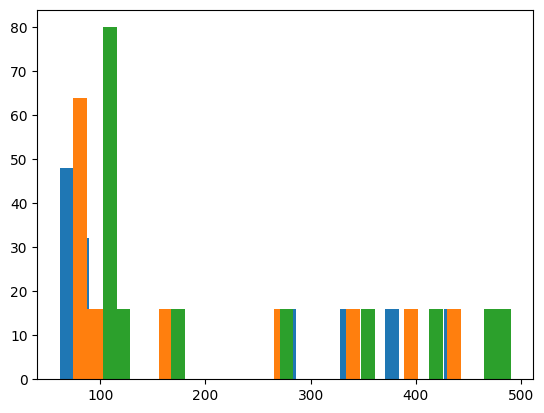

In [61]:
#check distributions of latency - mainly to ensure they are increasing
_ = plt.hist(df_200['99th'], bins=30)
_ = plt.hist(df_400['99th'], bins=30)
_ = plt.hist(df_600['99th'], bins=30)

train score = 0.996 test score = 0.002


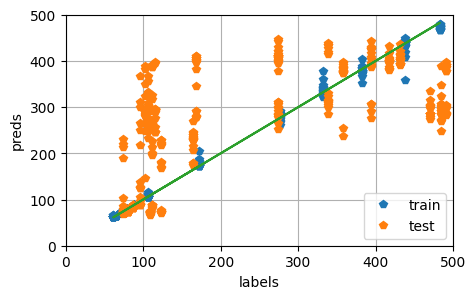

In [91]:
'''
Experiment 1:

Train on 200k and test on 400k/600k

The model doesn't generalize i.e. while train errors are low,
test errors are very high (R^2 ~ 0)

There are two obvious reasons for this:

a. during training, the model never had to learn patterns that help it predict QPS since QPS was uniform across
the training set. Training on a random split of the combined 200k/400k/600k should indicate whether this is true
(see below)

b. There's no information in the eigenvalue spectrum about the QPS i.e. the eigenvalue spectra don't change
as QPS changes (everything else being fixed). To be clear, "fixed" here doesn't mean constant - everything is a 
statistical quantity i.e. a random variable.
'''

lat_col = '99th'

scale = True
ratios = True
log = False

scorer = r2_score

model = RandomForestRegressor()

model, train_score, test_score = train(model,
                                       lat_col,
                                       df_200, #train = 200k
                                       pd.concat([df_400, df_600], axis=0), #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')

In [71]:
'''
Experiment 2:

Run a separate train/test experiment on each QPS (using run_exp defined above)

Results: all the models are predictive (low errors, R^2 ~ 1)

This indicates that the eigenvalue spectrum does have useful information to predict latency
across different QPS values
'''

for df in df_200, df_400, df_600:
    print('------------------------')
    for model in LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor():

        score_list, model, feat_col_names = run_exp(model,
                                                    df_600,
                                                    scale=True, 
                                                    ratios=True, 
                                                    log=False, 
                                                    n_iter=10, 
                                                    scorer=r2_score,
                                                    plot=False) #change plot->True to see plots

        score_mean, score_std = np.mean([i[1] for i in score_list]), np.std([i[1] for i in score_list]) #no log
        print(f'model={model} {score_mean - score_std:.3f}--{score_mean:.3f}--{score_mean + score_std:.3f}\n')

------------------------
(134, 26) (58, 26)
model=LinearRegression() 0.778--0.828--0.877

(134, 26) (58, 26)
model=Lasso() 0.799--0.835--0.871

(134, 26) (58, 26)
model=Ridge() 0.793--0.846--0.900

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.895--0.934--0.972

(134, 26) (58, 26)
model=RandomForestRegressor() 0.885--0.940--0.995

------------------------
(134, 26) (58, 26)
model=LinearRegression() 0.783--0.843--0.902

(134, 26) (58, 26)
model=Lasso() 0.849--0.866--0.882

(134, 26) (58, 26)
model=Ridge() 0.729--0.802--0.874

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.925--0.949--0.973

(134, 26) (58, 26)
model=RandomForestRegressor() 0.916--0.954--0.991

------------------------
(134, 26) (58, 26)
model=LinearRegression() 0.844--0.869--0.893

(134, 26) (58, 26)
model=Lasso() 0.791--0.848--0.905

(134, 26) (58, 26)
model=Ridge() 0.760--0.817--0.874

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.913--0.934--0.955

(134, 26) (58, 26)
model=RandomForestRegressor() 0.890--

In [93]:
'''
Experiment 3:

Look at spectra for same itr combination across different QPS values

Q: are the spectra different? (see cell below)
'''

df_600.groupby('desc').count() #16 cores per experiment

,avg,std,min,5th,10th,50th,90th,95th,99th,eig_0,...,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,itr,dvfs
desc,,,,,,,,,,,,,,,,,,,,,
0_100_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_10_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_200_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_20_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_250_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_2_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_300_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_30_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
0_350_0x1d00_135_600000,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


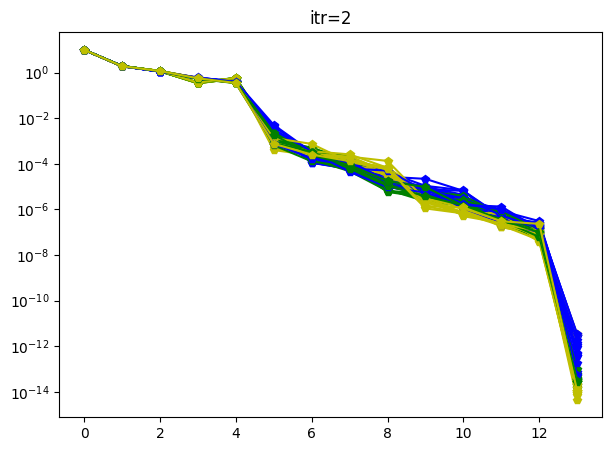

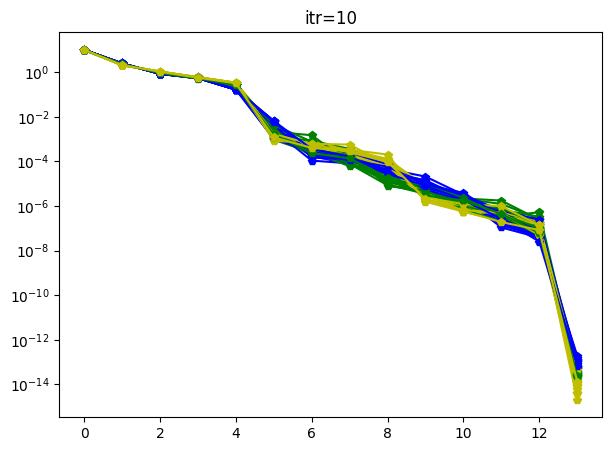

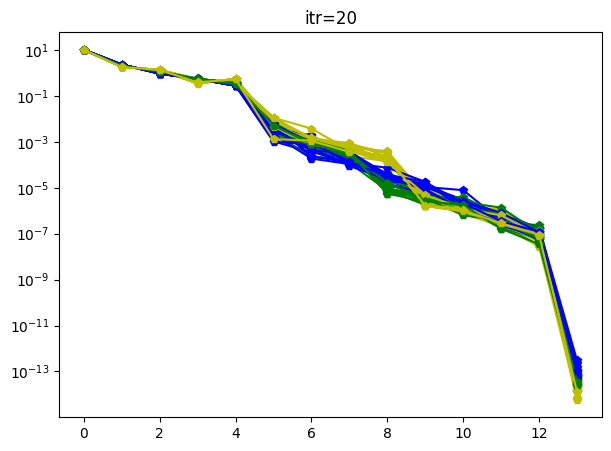

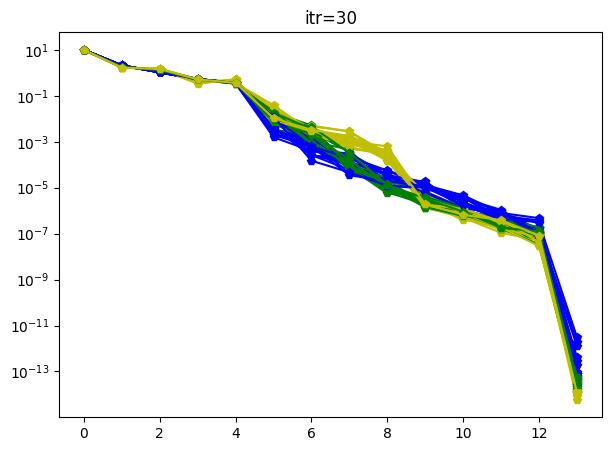

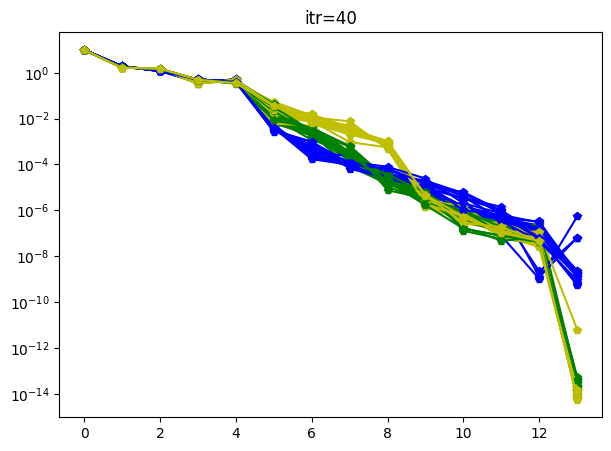

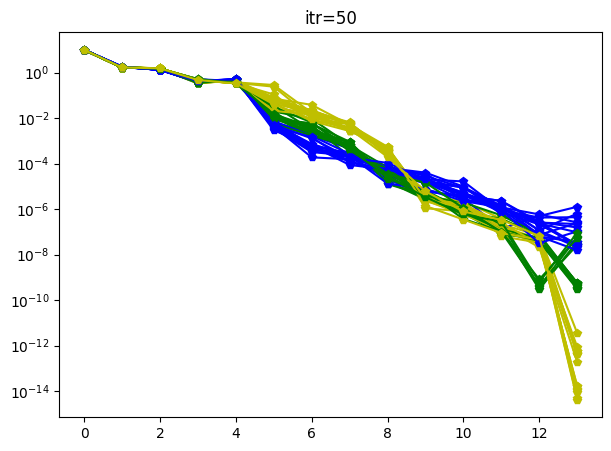

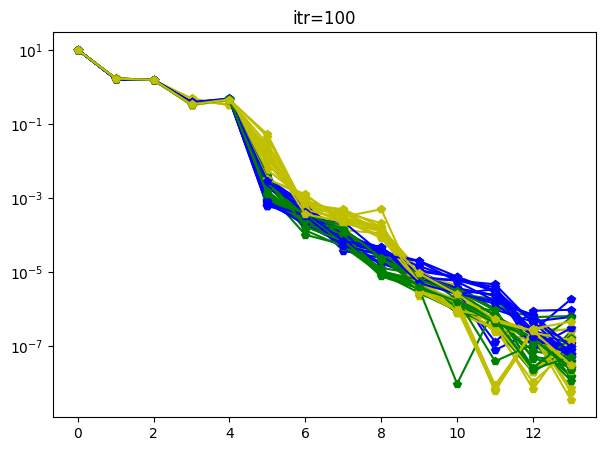

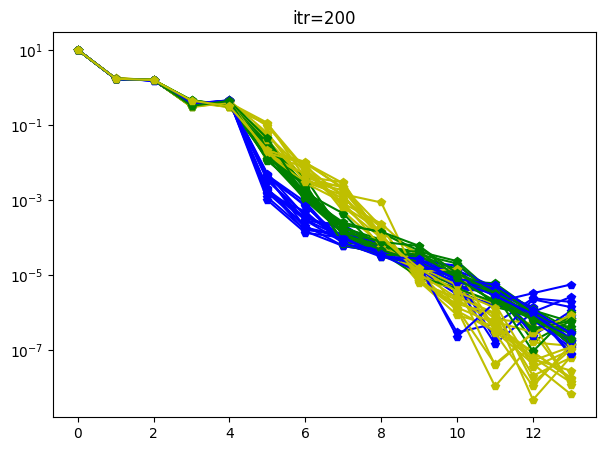

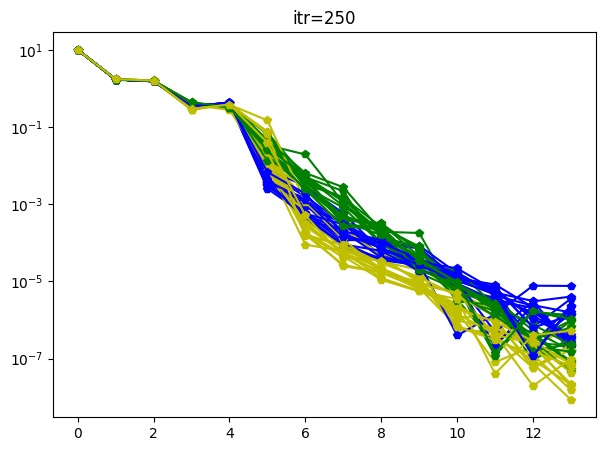

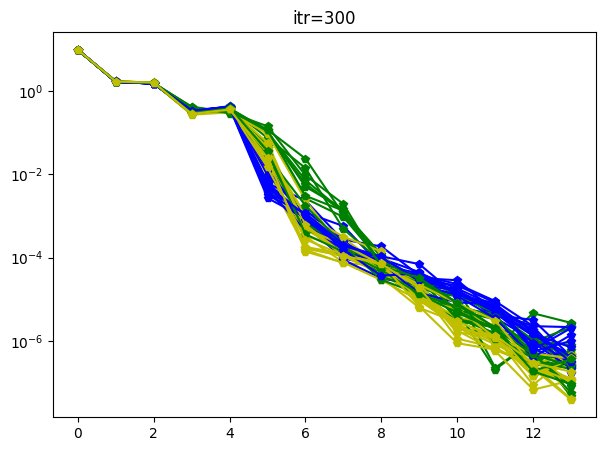

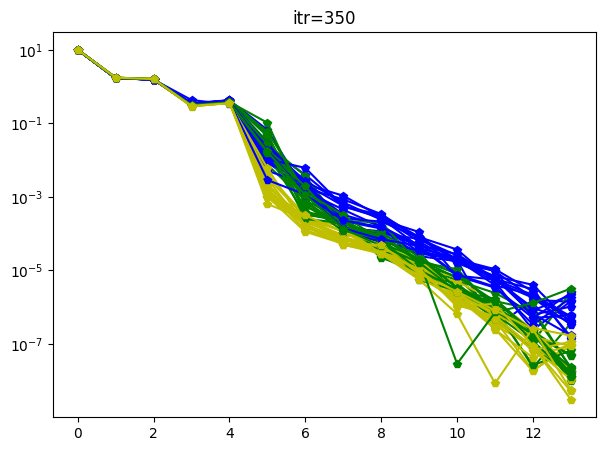

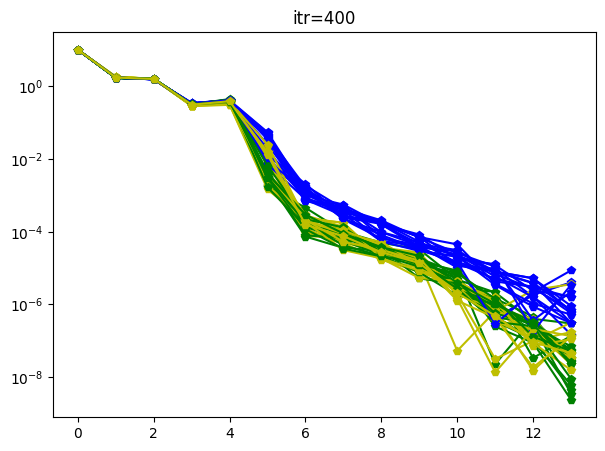

In [105]:
'''
Experiment 3 (same as above):

- There's a lot of noise in the eigenvalues across cores BUT
there are some clear patterns of distribution in the intermediate
and low eigenvalues

- This suggests that training of some QPS values will help
'''

for itr in np.sort(df_200.itr.unique()):

    key=f'0_{itr}_0x1d00_135'

    plt.figure(figsize=(7,5))
    plt.title(f'itr={itr}')
    for i in range(16):
        plt.plot(df_200[df_200.desc==f'{key}_200000'].iloc[i][eig_cols].tolist(), 'p-', color='b', label='200k')
        plt.plot(df_400[df_400.desc==f'{key}_400000'].iloc[i][eig_cols].tolist(), 'p-', color='g', label='400k')
        plt.plot(df_600[df_600.desc==f'{key}_600000'].iloc[i][eig_cols].tolist(), 'p-', color='y', label='600k')
    plt.yscale('log')

(403, 26) (173, 26)
model=RandomForestRegressor() 0.912--0.933--0.953



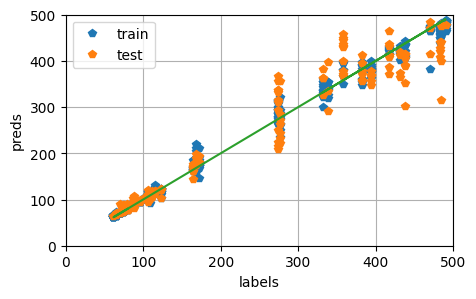

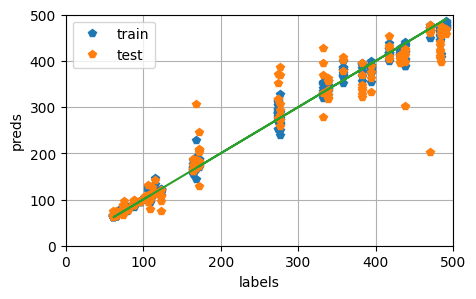

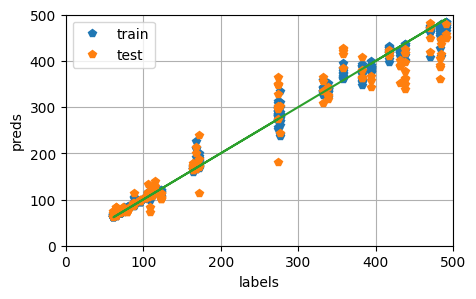

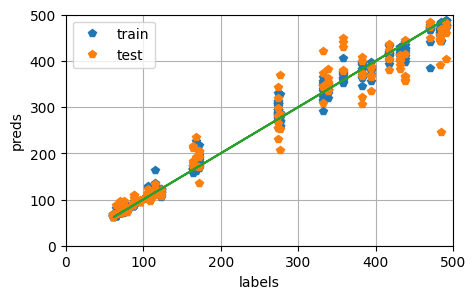

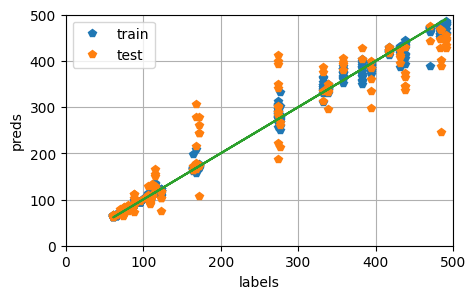

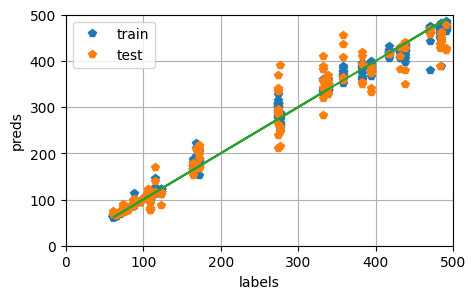

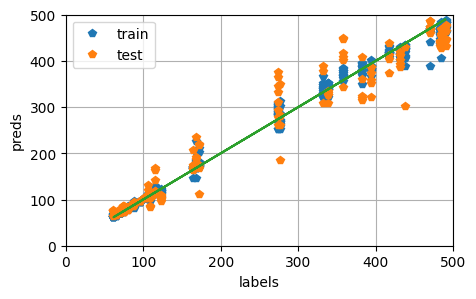

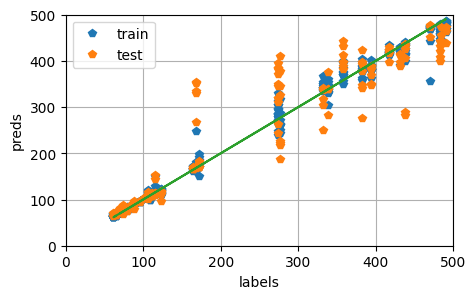

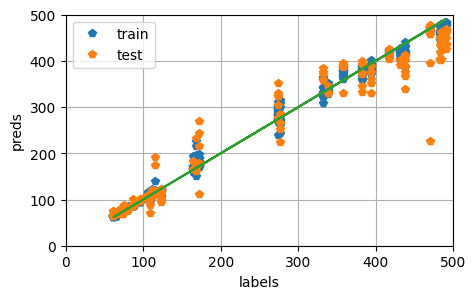

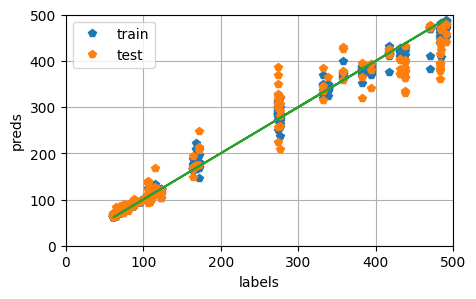

In [110]:
'''
Experiment 4:

Train on random split of union of QPS values

This model does very well since it's training on all QPS values (70% of the data)
and testing on the rest (30%)

This suggests another experiment: train on 200k, 600k and test on 400k (experiment 5)
'''

#for model in LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor():
for model in [RandomForestRegressor()]:
    score_list, model, feat_col_names = run_exp(model,
                                                pd.concat([df_200, df_400, df_600], axis=0),
                                                scale=True, 
                                                ratios=True, 
                                                log=False, 
                                                n_iter=10, 
                                                scorer=r2_score,
                                                plot=True) #change plot->True to see plots

    score_mean, score_std = np.mean([i[1] for i in score_list]), np.std([i[1] for i in score_list]) #no log
    print(f'model={model} {score_mean - score_std:.3f}--{score_mean:.3f}--{score_mean + score_std:.3f}\n')

train score = 0.993 test score = 0.824
train score = 0.992 test score = 0.216
train score = 0.993 test score = 0.813


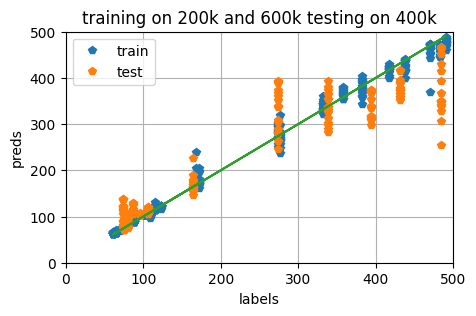

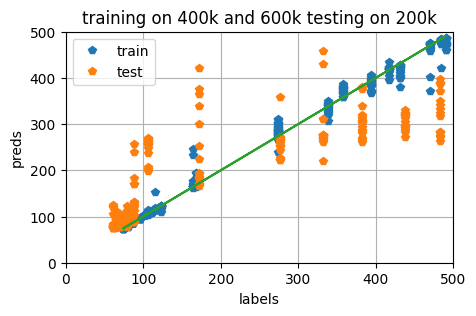

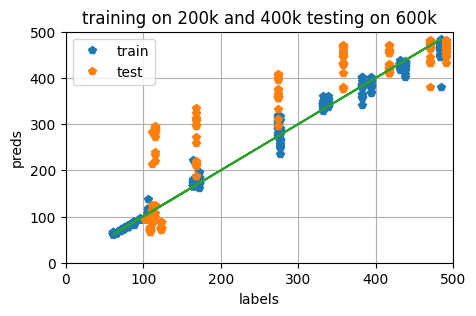

In [122]:
'''
Experiment 5:

There are three experiments - each one involves training on two
QPS values and leaving out one for testing

Training on 200k and 600k and testing on 400k works well - this is
expected since there is QPS info in the eigenvalues and we are 
not extrapolating along the QPS axis

Training on 400k/600k and testing on 200k does not generalize well -
in a sense, this is expected because we are now extrapolating along
the QPS axes. A better model might be able to do the non-linear extrapolation
(GPs, a small MLP).

Training on 200k/400k and testing on 600k does surprising well - would
expect same effect as testing on 200k since we are extrapolating.

Based on a cursory inspection of the plots below, the 200k testing has high
errors because of high itr values where latency starts saturating (because of
the SLA). Including that non-linear behavior in training helps. Needs more
rigorous analysis.
'''

scale = True
ratios = True
log = False

scorer = r2_score

model = RandomForestRegressor()

model, train_score, test_score = train(model,
                                       lat_col,
                                       pd.concat([df_200, df_600], axis=0),
                                       df_400, #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')
_ = plt.title(f'training on 200k and 600k testing on 400k')

model, train_score, test_score = train(model,
                                       lat_col,
                                       pd.concat([df_400, df_600], axis=0),
                                       df_200, #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')
_ = plt.title(f'training on 400k and 600k testing on 200k')

model, train_score, test_score = train(model,
                                       lat_col,
                                       pd.concat([df_200, df_400], axis=0),
                                       df_600, #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')
_ = plt.title(f'training on 200k and 400k testing on 600k')